# Calculation of exchange-correlation holes using the example of the hydrogen molecule

This script calculates and evaluates the electron density and the exchange-correlation holes of the hydrogen molecule. It can easily be adapted to other bond lengths as well as other molecules. The position of the reference electron can be varied.

Requirements: This Notebook has been tested with PySCF 1.7.1 and Matplotlib 3.2.1

In [1]:
from pyscf import gto, scf, fci, ci, ao2mo
from pyscf.dft.numint import eval_ao
import numpy as np
import math as ma
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('font', size=28)
plt.rc('axes', titlesize=28, labelsize=28)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('legend', fontsize=28)
plt.rc('figure', titlesize=28)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['ytick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

# Build Molecule

For the example of the hydrogen molecule in singlet state (`spin=0`) full configuration interaction (FCI) calculations were done, in which a cc-pVTZ basis set was used.

First, we set the position of one electron at $\boldsymbol{r}_1 = \boldsymbol{r}_{ref}$ to be 0.3 bohr (`e_ref=0.3`) next to the right nucleus. Also, the reference electron is set at the origin.

In [2]:
basisset = 'cc-pVTZ'
e_ref = 0.3              # Distance between the right nucleus and the reference electron (e_ref-nuch_b) 
spin = 0                 # spin state of the molecule (0 or 2)
steps = 300              # increase for higher resolution, value needs to be large enough 
                         # in order to give reasonable results at the evaluation of the xchole 
                         # at iso-density lines.
bonddist = 1.4           # bond distance between hydrogen nuclei in bohr

In [3]:
# these are the colors used later for the plots
if spin == 0 :
    denscolor = 'dodgerblue'
    xcholecolor = 'b'
if spin == 2 :
    denscolor = 'r'
    xcholecolor = 'darkorange'

The molecule can be changed here

In [4]:
nuc_b = 0.0-e_ref        # position of first (right) nucleus
nuc_a = nuc_b-bonddist   # position of the second (left) nucleus
nroots = 4 

mol = gto.Mole()
mol.atom = 'H 0.0 0.0 %f; H 0.0 0.0 %f' %(nuc_b,nuc_a)
mol.charge = 0
mol.unit = 'Bohr'
mol.spin = spin
mol.basis = basisset
mol.build()
nelec_a = (mol.nelectron + mol.spin) // 2 
nelec_b = mol.nelectron - nelec_a 
nelec_tot = nelec_a + nelec_b
nelec = (nelec_a, nelec_b)

print('Bond length: ', bonddist,'bohr')
print('Spin state: ', spin)
print('Basis set: ', mol.basis)
print('Number of electrons: ', nelec_a,'alpha, ', nelec_b,'beta')

Bond length:  1.4 bohr
Spin state:  0
Basis set:  cc-pVTZ
Number of electrons:  1 alpha,  1 beta


# Hartree Fock

In [5]:
myhf = scf.RHF(mol)
myhf.scf()

norb = myhf.mo_coeff.shape[1]

converged SCF energy = -1.13296052548289


# CI and RDM

Here the CI calculation is performed and the 1-RDM and 2-RDM are obtained. 
Change `fullci=False` to perform CISD calculations instead of Full-CI.

In [6]:
fullci = True

if fullci:
    cisolver = fci.FCI(mol, myhf.mo_coeff)
    e, ci0 = cisolver.kernel(nroots=nroots) 

    print ('All CI energies', e)
    e = e[0]
    ci0 = ci0[0] #FCI wfn vector(s)

    print('E(FCI) = %.12f' % (e + mol.energy_nuc())) 
    
    # computation of the 1-RDM and 2-RDM
    rdm1, rdm2 = cisolver.make_rdm12(ci0, norb, nelec)

else: # use CISD instead of Full-CI
    if spin == 0:
        cisdsolver = ci.CISD(myhf).run()
        rdm1 = cisdsolver.make_rdm1() #Spin-traced one-particle density matrix in MO basis (the occupied-virtual blocks from the orbital response contribution are not included).
        rdm2 = cisdsolver.make_rdm2() #Spin-traced two-particle density matrix in MO basis 

    if spin == 2:
        cisdsolver = ci.UCISD(myhf).run()
        rdm1a, rdm1b = cisdsolver.make_rdm1()
        rdm2aa, rdm2ab, rdm2bb = cisdsolver.make_rdm2()
        
        rdm1 = rdm1a + rdm1b
        rdm2 = rdm2aa + rdm2ab + rdm2bb
        rdm2 = rdm2 + np.swapaxes(np.swapaxes(rdm2ab,0,2), 1,3)

# test normalization of the 1-RDM and 2-RDM
rdm1from2 = (1.0/(nelec_tot-1)) * np.einsum('pqrr->pq',rdm2) #1-RDM from 2-RDM: r1=r1', r2=r2'

print ('Normalization of 1-RDM:', np.einsum('pp', rdm1),'(rdm1)', np.einsum('pp', rdm1from2),'(rdm1from2)')
print ('Normalization of 2-RDM:', np.einsum('pprr', rdm2),'(rdm2)')

All CI energies [-1.17233459 -0.77935527 -0.67601936 -0.61884143]
E(FCI) = -0.458048879258
Normalization of 1-RDM: 2.0000000000000004 (rdm1) 1.999999999999999 (rdm1from2)
Normalization of 2-RDM: 1.999999999999999 (rdm2)


Normalization of the 2-RDM:
$ \int \Gamma_2 (\boldsymbol{r}_1,\boldsymbol{r}_2,\boldsymbol{r}_1,\boldsymbol{r}_2) \,\text{d}r_1\,\text{d}r_2 = N (N-1) $

# Reference electron

The reference electron is placed at the origin. 

In [7]:
refcoord = np.zeros((1,3))
refcoord = [[0.0, 0.0, 0.0]] # position of the reference electron 

ref_ao_value = eval_ao(mol, refcoord)
ref_mo_value = np.dot(ref_ao_value, myhf.mo_coeff)

dens_ref = np.einsum('pq,ip,iq->i', rdm1, ref_mo_value, ref_mo_value)
intrdm = np.einsum('pqrs,p,q->rs', rdm2, ref_mo_value[0,:], ref_mo_value[0,:])

print('Density at reference electron position: ', dens_ref)

Density at reference electron position:  [0.21131576]


# Evaluation

The electron density and the xchole can be calculated in terms of the 2-RDM, which is computed as a matrix of the coefficients $c_{pqrs}$. 

> $\Gamma_2 (\boldsymbol{r}_1,\boldsymbol{r}_2,\boldsymbol{r}_1',\boldsymbol{r}_2') = \sum_{pqrs} c_{pqrs}\phi^*_p(\boldsymbol{r}_1)\phi^*_q(\boldsymbol{r}_2) \phi_r(\boldsymbol{r}_1') \phi_s(\boldsymbol{r}_2')$



$ \rho (\boldsymbol{r}) = \int \Gamma_2 (\boldsymbol{r}_1,\boldsymbol{r}_2,\boldsymbol{r}_1',\boldsymbol{r}_2') \,\text{d}^3 r_2 = \sum_{pr} c_{pr} \phi_p^*(\boldsymbol{r}) \phi_r (\boldsymbol{r}) $

$\rho_{xc}^{hole} (\boldsymbol{r}_{2}, \boldsymbol{r}_{ref}) = \frac{\rho_2(\boldsymbol{r}_{2}, \boldsymbol{r}_{ref})}{\rho(\boldsymbol{r}_{ref})} -  \rho (\boldsymbol{r}_2) $

# Plots along internuclear z-axis

In [8]:
axlim = 5

# set the z coordinates 
coords = np.zeros((steps,3))
zcoord = np.linspace(nuc_a-axlim, nuc_b+e_ref+axlim, steps) 
coords[:,2] = zcoord

# evaluation of AO and MO values
ao_value = eval_ao(mol, coords)
mo_value = np.dot(ao_value, myhf.mo_coeff)

# computation of the electron density and the xc hole
dens = np.einsum('pq,ip,iq->i', rdm1, mo_value, mo_value)
xchole = np.einsum('rs,ir,is->i', intrdm, mo_value, mo_value)
xchole = (xchole / dens_ref) - dens

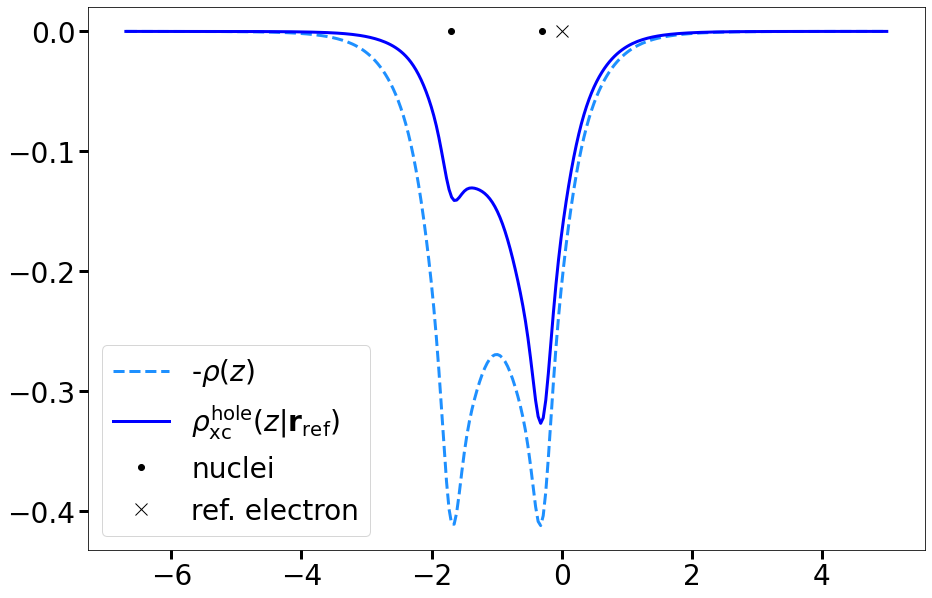

In [9]:
plt.figure(figsize=(15,10))
plt.plot(zcoord,-dens,color=denscolor,linestyle='--',label='-$\\rho (z)$')
plt.plot(zcoord,xchole,color=xcholecolor,label='$\\rho^\\mathrm{hole}_\\mathrm{xc}$($z$$|$$\\bf{r}$$_\\mathrm{ref}$)')
plt.plot([nuc_a,nuc_b],[0.0,0.0],'k.',markersize=12,label='nuclei')
plt.plot([refcoord[0][2]],[0.0],'kx',markersize=12,label='ref. electron')
plt.legend()
plt.show()

# Cylindrical integrated plots

The normalization of the xc hole is given by 

$ \int \rho_{\text{xc}}^{\text{hole}} (\boldsymbol{r} | \boldsymbol{r}_{\text{ref}}) = -1 $.

In order to recover the normalization of the xc hole in the visualiszation, the cylindrically-averaged density and xc hole were plotted

$ \rho_{\text{cx,cy-av}}^{\text{hole}} (z|\boldsymbol{r}_{\text{ref}}) = \int_0^{2\pi} \int_0^\infty \rho_{\text{cx}}^{\text{hole}} (\boldsymbol{r} = r,\varphi,z|\boldsymbol{r}_{\text{ref}}) \, r \,\text{d}r\text{d}\varphi $.

In [10]:
# set the x and z coordinates 
zcoord_cy = np.linspace(nuc_a-axlim, nuc_b+e_ref+axlim, steps)
dz_cy = zcoord_cy[1] - zcoord_cy[0]

xcoord_cy = np.linspace(0.0, 10, steps)
dx_cy = xcoord_cy[1] - xcoord_cy[0]

dens_cy = np.zeros_like(zcoord_cy)
xchole_cy = np.zeros_like(zcoord_cy)

coords_cy = np.zeros((xcoord_cy.size,3))

for i, z in enumerate(zcoord_cy) :
    coords_cy[:,:] = 0.0
    coords_cy[:,2] = z
    coords_cy[:,0] = xcoord_cy

    # evaluation of AO and MO values
    ao_value_cy = eval_ao(mol, coords_cy)
    mo_value_cy = np.dot(ao_value_cy, myhf.mo_coeff)

    # computation of the electron density and the xc hole
    densx_cy = np.einsum('pq,ip,iq->i', rdm1, mo_value_cy, mo_value_cy)
    xcholex_cy = np.einsum('rs,ir,is->i', intrdm, mo_value_cy, mo_value_cy)
    xcholex_cy = (xcholex_cy / dens_ref) - densx_cy
    
    # cylindrical integration of the electron density and the xc hole
    dens_cy[i] = np.sum(densx_cy * xcoord_cy) * dx_cy * 2.0*np.pi
    xchole_cy[i] = np.sum(xcholex_cy * xcoord_cy) * dx_cy * 2.0*np.pi

int_dens_cy = np.sum(dens_cy) * dz_cy
int_xchole_cy = np.sum(xchole_cy) * dz_cy

print('Density Integral: ', int_dens_cy, '(should be N_electrons',nelec_tot,')')
print('XC Hole Integral: ', int_xchole_cy, '(should be -1)')

Density Integral:  1.9994791302502735 (should be N_electrons 2 )
XC Hole Integral:  -0.9997210042335555 (should be -1)


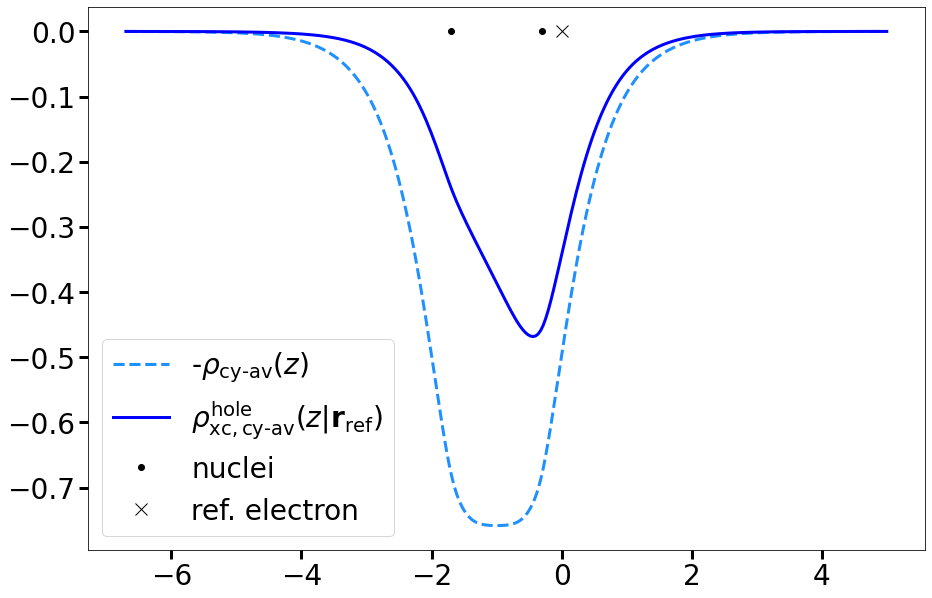

In [11]:
plt.figure(figsize=(15,10))
plt.plot(zcoord_cy,-dens_cy,color=denscolor,linestyle='--',label='-$\\rho _\\mathrm{cy\u2010av}(z)$')
plt.plot(zcoord_cy,xchole_cy,color=xcholecolor,label='$\\rho^\\mathrm{hole}_\\mathrm{xc,cy\u2010av}$($z$$|$$\\bf{r}$$_\\mathrm{ref}$)')
plt.plot([nuc_a,nuc_b],[0.0,0.0],'k.',markersize=12,label='nuclei')
plt.plot([refcoord[0][2]],[0.0],'kx',markersize=12,label='ref. electron')
plt.legend()
plt.show()

# Spherically integrated plots

$ \rho_{\text{cx,sph-av}}^{\text{hole}} (r|\boldsymbol{r}_{\text{ref}}) = \int_0^{2\pi} \int_0^\pi \rho_{\text{cx}}^{\text{hole}} (\boldsymbol{r} = r,\theta,\varphi|\boldsymbol{r}_{\text{ref}}) \, sin(\theta) \,\text{d}\theta\text{d}\varphi $

In [12]:
# set the r, theta and phi coordinates 
rcoord = np.linspace(0.0, axlim, steps) 
dr = rcoord[1] - rcoord[0]

theta = np.linspace(0.0, np.pi, round(steps/2)) 
dtheta = theta[1] - theta[0]

phi = np.linspace(0.0, 2.0*np.pi, steps) 
dphi = phi[1] - phi[0]

xchole_sphint = np.zeros_like(rcoord)
dens_sphint = np.zeros_like(rcoord)
xchole_thetaint = np.zeros_like(theta)
dens_thetaint = np.zeros_like(theta)

coords_sphint = np.zeros((phi.size,3))

for i, r in enumerate(rcoord) :
    dens_thetaint[:] = 0.0
    xchole_thetaint[:] = 0.0
    
    for j, th in enumerate(theta) :
        
        coords_sphint[:,0] = r * np.sin(th) * np.cos(phi)
        coords_sphint[:,1] = r * np.sin(th) * np.sin(phi)
        coords_sphint[:,2] = r * np.cos(th)

        # evaluation of AO and MO values
        ao_value_sphint = eval_ao(mol, coords_sphint)
        mo_value_sphint = np.dot(ao_value_sphint, myhf.mo_coeff)

        # computation of the electron density and the xc hole
        dens_phiint = np.einsum('pq,ip,iq->i', rdm1, mo_value_sphint, mo_value_sphint)
        xchole_phiint = np.einsum('rs,ir,is->i', intrdm, mo_value_sphint, mo_value_sphint)
        xchole_phiint = (xchole_phiint / dens_ref) - dens_phiint
        
        # spherical integration of the electron density and the xc hole
        dens_thetaint[j] = np.sum(dens_phiint) * dphi
        xchole_thetaint[j] = np.sum(xchole_phiint) * dphi
    
    dens_sphint[i] = sum(dens_thetaint * np.sin(theta)) * dtheta
    xchole_sphint[i] = sum(xchole_thetaint * np.sin(theta)) * dtheta
    
int_dens_sphint = np.sum(dens_sphint * rcoord**2) * dr
print('Density Integral: ', int_dens_sphint, '(should be N_electrons',nelec_tot,')')

int_xchole_sphint = np.sum(xchole_sphint * rcoord**2) * dr
print('XC Hole Integral: ', int_xchole_sphint, '(should be -1)')

Density Integral:  2.0015202706160657 (should be N_electrons 2 )
XC Hole Integral:  -1.0015507019289378 (should be -1)


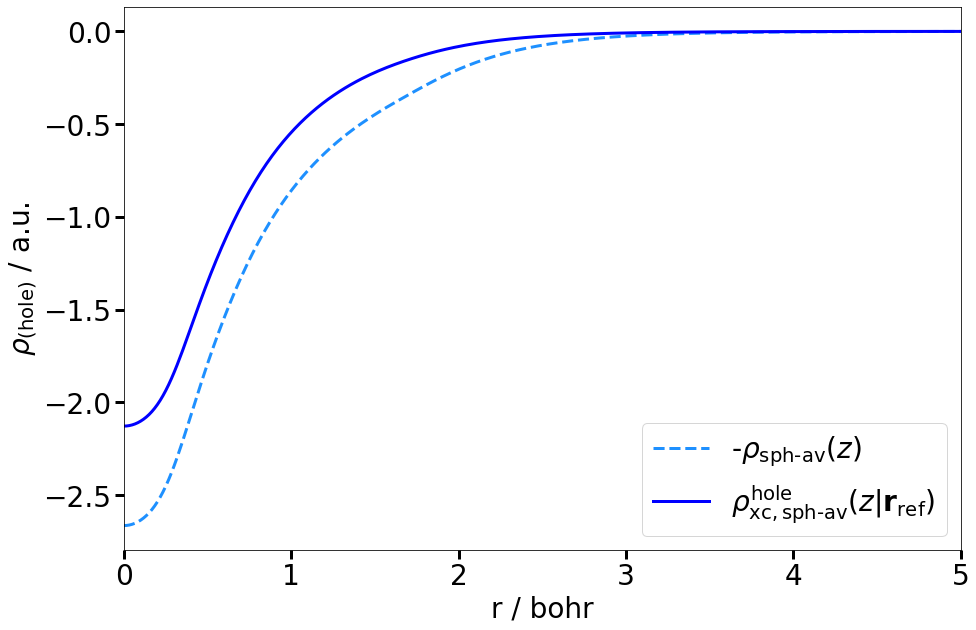

In [13]:
plt.figure(figsize=(15,10))
plt.xlim(0,5)
plt.xlabel(r'r / bohr')
plt.ylabel(r'$\rho_\mathrm{(hole)}$ / a.u.')
plt.plot(rcoord,-dens_sphint,color=denscolor,linestyle='--',label='-$\\rho _\\mathrm{sph\u2010av}(z)$')
plt.plot(rcoord,xchole_sphint,color=xcholecolor,label='$\\rho^\\mathrm{hole}_\\mathrm{xc,sph\u2010av}$($z$$|$$\\bf{r}$$_\\mathrm{ref}$)')
plt.legend()
plt.show()

# Contour plots

In [14]:
# set the x and z coordinates 
zcoord_iso = np.linspace(nuc_a-e_ref-1, nuc_b+e_ref+1, steps*10)
xcoord_iso = np.linspace(-nuc_b-e_ref-2, nuc_b+e_ref+2, steps*10)

dens_iso = []
xchole_iso = []
coords_iso = np.zeros((xcoord_iso.size,3))

for i, x in enumerate(xcoord_iso) :
    coords_iso[:,:] = 0.0
    coords_iso[:,0] = x
    coords_iso[:,2] = zcoord_iso

    # evaluation of AO and MO values
    ao_value_iso = eval_ao(mol, coords_iso)
    mo_value_iso = np.dot(ao_value_iso, myhf.mo_coeff)

    # computation of the electron density and the xc hole
    densx_iso = np.einsum('pq,ip,iq->i', rdm1, mo_value_iso, mo_value_iso)
    xcholex_iso = np.einsum('rs,ir,is->i', intrdm, mo_value_iso, mo_value_iso)
    xcholex_iso = (xcholex_iso / dens_ref) - densx_iso
    
    dens_iso.append(densx_iso)
    xchole_iso.append(xcholex_iso)

In [15]:
# Try to set offset that there is only one possible index set for the position of the reference electron
offset = 0.002
z_index = []
x_index = []

# evaluate the x index of the position of the reference electron
for i,coorval in enumerate(xcoord_iso):
    if coorval>(nuc_b+e_ref-offset) and coorval<(nuc_b+e_ref+offset):
        x_index.append(i)
        print(i,coorval)

# evaluate the z index of the position of the reference electron
for i,coorval in enumerate(zcoord_iso):
    if coorval>(nuc_b+e_ref-offset) and coorval<(nuc_b+e_ref+offset):
        z_index.append(i)
        print(i,coorval)

if len(x_index) > 1:
    print('multiple x-values, took last one')
    x_index = x_index[-1]
if len(z_index) > 1:
    print('multiple z-values, took last one')
    z_index = z_index[-1]

print('Coords ref electron:',z_index,x_index)
print('Density at position of ref. electron:',dens_iso[x_index][z_index])

1499 -0.0006668889629877217
1500 0.0006668889629874997
2248 -0.0016672224074691933
2249 -0.0003334444814941939
2250 0.0010003334444812495
multiple x-values, took last one
multiple z-values, took last one
Coords ref electron: 2250 1500
Density at position of ref. electron: 0.2107912677616134


In [16]:
isoline_z = []
isoline_x = []
iso_xchole = []
iso_angle = []
offset = 0.0005

# evaluation of the iso-density lines and the corresponding xchole values 
for i in range(len(dens_iso)):
    for j in range(len(dens_iso)):
        if dens_iso[i][j]>(dens_iso[x_index][z_index]-offset) and dens_iso[i][j]<(dens_iso[x_index][z_index]+offset):
            iso_xchole.append(xchole_iso[i][j])
            isoline_z.append(zcoord_iso[j])
            isoline_x.append(xcoord_iso[i])

print('len isoline',len(isoline_z),len(isoline_x),len(iso_xchole))

len isoline 7284 7284 7284


In [17]:
coorinput = []
coor_angle = []

# sorting the computed isodensity and xc hole values
for i in range(len(isoline_x)):    
    coor_angle.append(ma.atan2(isoline_x[i],isoline_z[i]+bonddist/2+e_ref))
    coorinput.append((coor_angle[i],iso_xchole[i],isoline_x[i],isoline_z[i]))

sort_coorinput = sorted(coorinput, key=lambda tup: tup[0])

sorted_angle = [x[0] for x in sort_coorinput]
sorted_xchole = [x[1] for x in sort_coorinput]
sorted_isoline_x = [x[2] for x in sort_coorinput]
sorted_isoline_z = [x[3] for x in sort_coorinput]

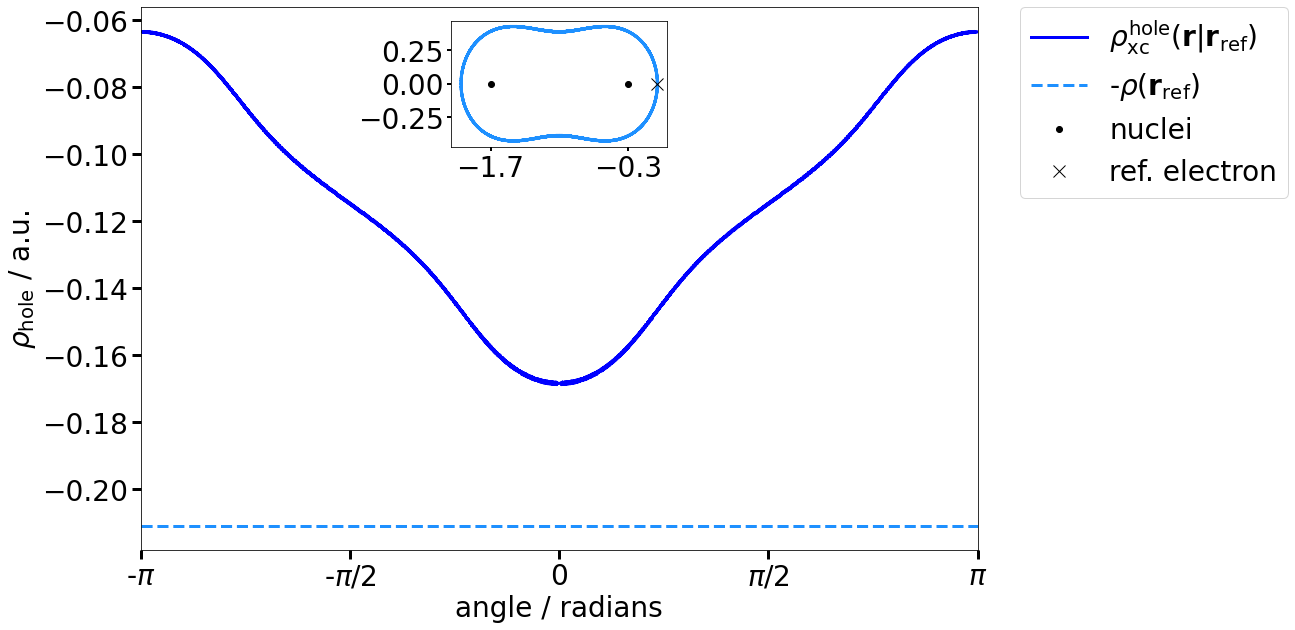

In [18]:
plt.figure(figsize=(15,10))
plt.xlim(-np.pi,np.pi)
plt.ylabel(r'$\rho_\mathrm{hole}$ / a.u.')
plt.xlabel(r'angle / radians')
plt.plot(sorted_angle,sorted_xchole,color=xcholecolor,label='$\\rho^\\mathrm{hole}_\\mathrm{xc}$($z$$|$$\\bf{r}$$_\\mathrm{ref}$)')
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[ r'-$\pi$', r'-$\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax = plt.gca()
ax.axhline(y=-dens_iso[x_index][z_index],color=denscolor,linestyle='--',label='-$\\rho$($\\bf{r}$$_\\mathrm{ref}$)')

nuclei_legend = mlines.Line2D([], [],lw=0, color='k', marker='.',markersize=12, label='nuclei')
dens_legend = mlines.Line2D([], [], color=denscolor, linestyle='--', label='-$\\rho$($\\bf{r}$$_\\mathrm{ref}$)')
xc_legend = mlines.Line2D([], [], color=xcholecolor, linestyle='-',fillstyle='right', label='$\\rho^\\mathrm{hole}_\\mathrm{xc}$($\\bf{r}$$|$$\\bf{r}$$_\\mathrm{ref}$)')
eref_legend = mlines.Line2D([], [],lw=0 , color='k', marker='x',markersize=12, label='ref. electron')
plt.legend(handles=[xc_legend,dens_legend,nuclei_legend,eref_legend],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)

axins = inset_axes(ax, 3.0, 1.75, loc='upper center')
axins.tick_params(width=2,length=4)
axins.set_xticks([nuc_a,nuc_b])
axins.plot(sorted_isoline_z,sorted_isoline_x,color=denscolor)
axins.plot([nuc_a,nuc_b],[0.0,0.0],'k.',markersize=12)
axins.plot(0.0,0.0,'kx',markersize=12)

plt.show()